In [ ]:
# With pip:
!pip install facenet-pytorch

from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

     |████████████████████████████████| 1.9MB 10.0MB/s 


In [ ]:
!pip install pafy
!pip install youtube_dl

     |████████████████████████████████| 1.9MB 8.6MB/s 


In [ ]:
import os
import imageio
import scipy.io
from sklearn import preprocessing
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [ ]:
# Load face detector (cropar imagem)
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model (retirar features)
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

#Tentativa de rodar o modelo pro dataset inteiro(ainda não funciona)


In [ ]:
!wget "http://vis-www.cs.umass.edu/lfw/lfw.tgz"

--2021-07-14 16:13:10--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  34.2MB/s    in 5.6s    

2021-07-14 16:13:16 (30.9 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
#!mv 'lfw.zip' lfw.zip
!gunzip lfw.tgz
!tar -xf lfw.tar

In [ ]:
!wget "http://vis-www.cs.umass.edu/lfw/lfw-names.txt"

--2021-07-14 16:13:22--  http://vis-www.cs.umass.edu/lfw/lfw-names.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94727 (93K) [text/plain]
Saving to: ‘lfw-names.txt’

lfw-names.txt       100%[===================>]  92.51K   555KB/s    in 0.2s    

2021-07-14 16:13:23 (555 KB/s) - ‘lfw-names.txt’ saved [94727/94727]



In [ ]:
class DetectionPipelineDataset:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, root, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = None
        self.batch_size = batch_size
        self.resize = resize
        self.img_list = []
        self.labels = []
        self.labels_string = []

        self.img_list, self.labels, self.labels_string = self.read_directory(root)

        self.num_classes = len(np.unique(self.labels))
        #print(self.num_classes)

    def read_directory(self, root):
        _files = []
        _labels_string = []

        subfolders = os.listdir(root)  # read subfolders
        for subf in subfolders:
            files = os.listdir(os.path.join(root, subf))  # read files of each subfolder
            if(len(files)<15):
              continue
            for f in files:
                _files.append(os.path.join(root, subf, f))
                _labels_string.append(subf)

        le = preprocessing.LabelEncoder()
        _labels = le.fit_transform(_labels_string)
        #print(len(_files), len(_labels), len(_labels_string))

        return _files, _labels, _labels_string
    
    def __getitem__(self, index):
        
        img = imageio.imread(self.img_list[index])
        cl = self.labels[index]

        v_len = 1

        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)
      
        faces = []
        imgs = []
        for j in range(v_len):
            if j in sample:
                # Load img
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img)
                
                # Resize frame to desired size
                if self.resize is not None:
                    img = img.resize([int(d * self.resize) for d in img.size])
                imgs.append(img)

                # When batch is full, detect faces and reset frame list
                if len(imgs) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(imgs))
                    imgs = []

        return faces, cl, img, self.img_list[index], self.labels_string[index]

    def __len__(self):
        return len(self.img_list)  


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    return embeddings

In [ ]:
image_dataloader = None
dataset_dataloader = None
dataset_path = '/content/LFW/lfw'
# loading dataset or image
if dataset_path is not None:
    dataset = DetectionPipelineDataset(detector=mtcnn, root=dataset_path, batch_size=60, resize=0.25)
    #dataset_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True,
                                                         #num_workers=8, drop_last=False)

features = None
feature_file = "features.mat"
if feature_file is not None and os.path.isfile(feature_file):
    features = scipy.io.loadmat(feature_file)

X=[]
features_interno = None
classes = None
images = None
names = None
cropped_images = []
count = 0
save_img_results = True
print(len(dataset))

for faces, cls, crop_img, imgl_list, people in dataset:
    #print("faces:",faces,'\n',"cls:",cls,'\n',"crop_img:",crop_img,'\n',"imgl_list:",imgl_list,'\n',"people:",people)
    if(faces==[None]):
        continue
    if(faces[0]!=None):
        count += faces[0].size(0)
    if count % (dataset.batch_size*10) == 0:
        print('extracing deep features from the face {}...'.format(count))

    with torch.no_grad():
        X=process_faces(faces, resnet)
    print(X)
    if features_interno is None:
        
        features_interno = X
        images = [imgl_list]
        names = [people]
        if save_img_results is True:
            classes = [cls]
            cropped_images = crop_img
    else:
        names = np.concatenate((names, [people]), 0)
        features_interno = np.concatenate((features_interno, X), 0)
        images = np.concatenate((images, [imgl_list]), 0)
        if save_img_results is True:
            classes = np.concatenate((classes, [cls]), 0)
            cropped_images = np.concatenate((cropped_images, crop_img), 0)
    
    #print(len(features_interno), len(names), len(images))
    #if save_img_results is True:
        #print(cropped_images.size)
        #print(len(classes))

if save_img_results is True:
    result = {'name': names, 'feature': features_interno, 'class': classes, 'image': images,
                  'cropped_image': cropped_images}
else:
    result = {'name': names, 'feature': features_interno, 'image': images}    


if result is not None:
    if features is None:
        # if there is not features, use the recently extracted one as the current features
        features = result
    else:
        # otherwise, concatenate the existing features with the recently extracted ones
        features['feature'] = np.concatenate((features['feature'], result['feature']), 0)
        features['name'] = np.concatenate((features['name'], result['name']), 0)
        features['image'] = np.concatenate((features['image'], result['image']), 0)
    # save the current version of the features
    scipy.io.savemat(feature_file, features)



3595
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.5807231  0.58072305]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.689125 0.689125]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[

ValueError: ignored

#Rodar modelo para o vídeo(funcionando, mas imagem cropada sai avermelhada???)

In [ ]:
def download_youtube(url, output_folder='tmp'):
    #check_requirements(('pafy', 'youtube_dl'))
    import pafy

    v = pafy.new(url)
    filename = f"{v.videoid}[{v.title.replace(' ', '_')}].mp4"
    if output_folder == 'tmp':
        output_folder = tempfile.TemporaryDirectory().name
    
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True) # Create output folder if necessary

    video = v.getbest(preftype="mp4").download(filepath=os.path.join(output_folder, filename), quiet=True)

    return os.path.join(output_folder, filename)

In [ ]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        notDl = []
        haveDl = False
        filtered_files = []
        output_folder = 'videos'
        if 'youtube.com/' in filename.lower() or 'youtu.be/' in filename.lower():  # if is YouTube video
            haveDl = True
            try:
                filename = download_youtube(filename, output_folder)
                filtered_files.append(filename)
            except:
                notDl.append(filename)
        
        if haveDl and len(notDl) > 0:
                print(f'The following file(s) could not be downloaded : {notDl}.\nProceeding with the availabel files: {filtered_files}')
        print(filtered_files)
        
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(v_len)
        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)
        # Loop through frames
        faces = []
        frames = []
        for j in range(0,v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                #frames.append(frame)

                # When batch is full, detect faces and reset frame list
                #if len(frames) % self.batch_size == 0 or j == sample[-1]:
                faces.append(self.detector(frame))
                #frames = []
        
        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    for f in faces:
      plt.imshow(f[0].cpu().numpy().transpose(1,2,0))
      plt.show()
    faces = torch.cat(faces).to(device)
    
    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)
    
    return embeddings


['videos/-TXBxxPAtb0[Putin_em_cima_de_um_Urso_(Video_100%_Verídico!)].mp4']
278


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


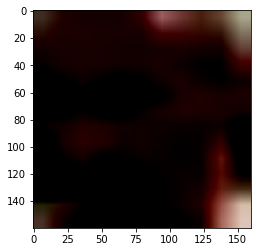

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


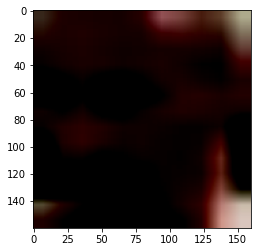

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


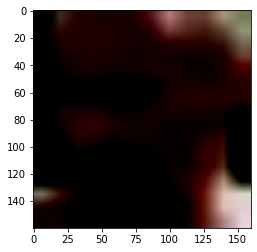

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


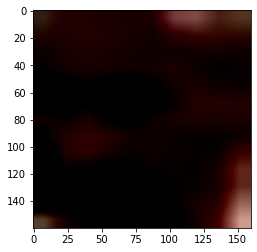

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


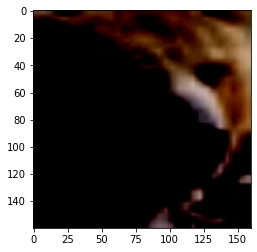

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


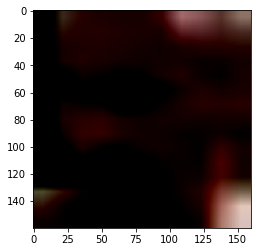

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


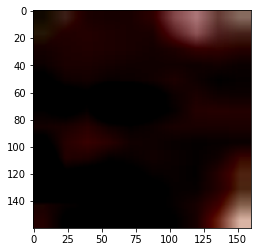

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


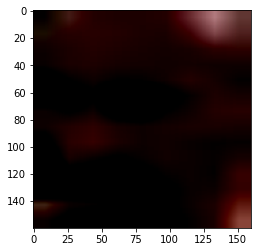

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


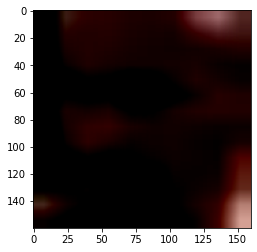

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


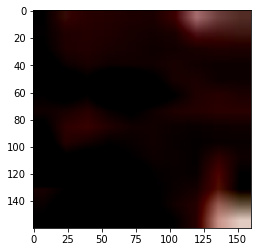

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


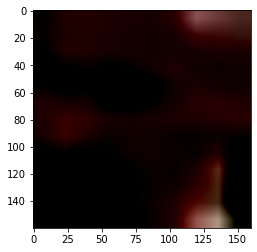

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


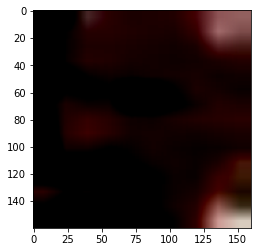

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


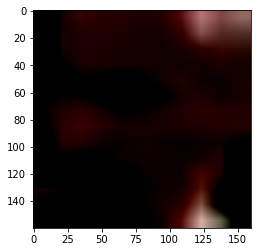

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


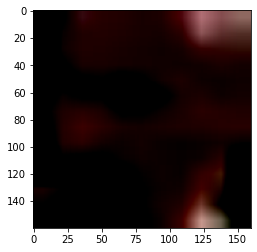

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


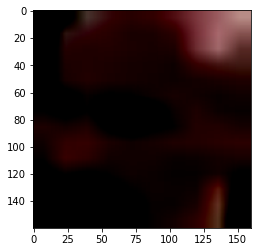

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


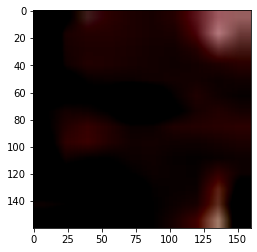

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


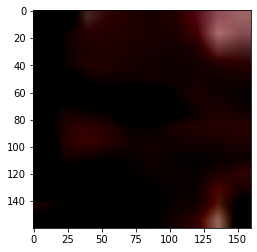

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


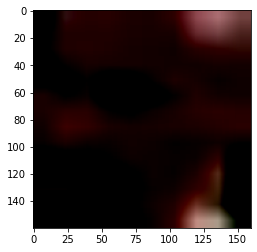

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


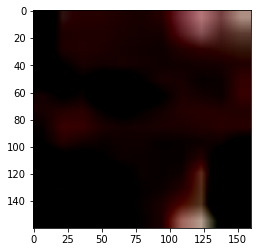

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


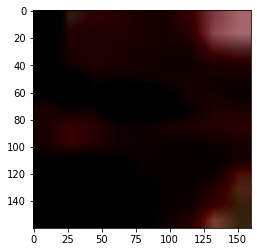

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


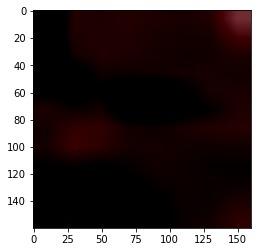

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


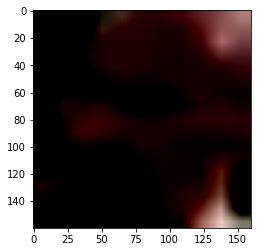

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


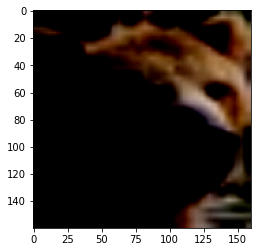

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


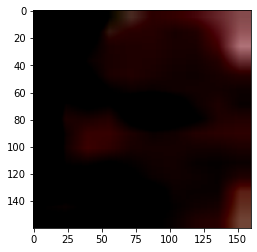

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


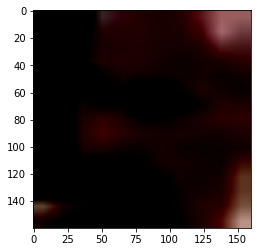

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


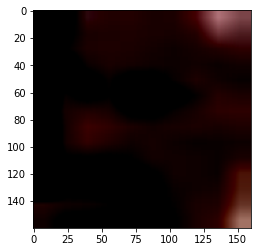

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


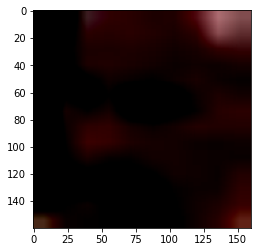

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


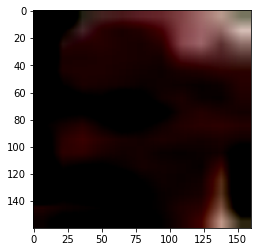

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


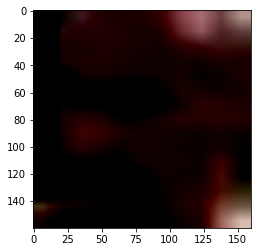

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


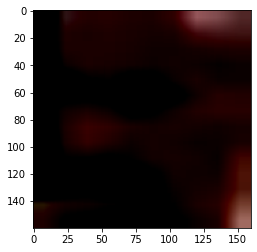

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


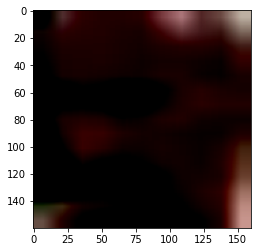

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


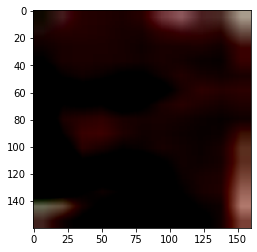

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


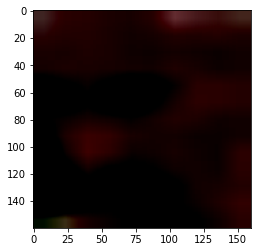

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


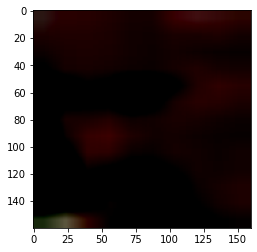

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


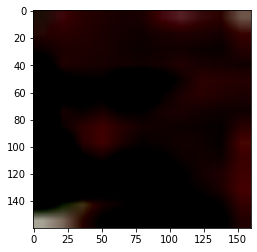

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


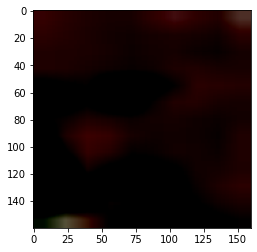

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


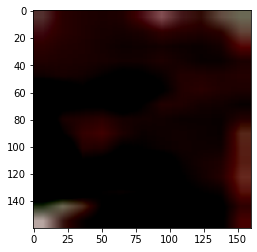

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


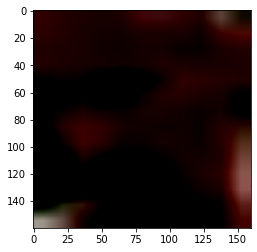

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


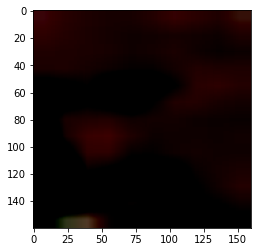

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


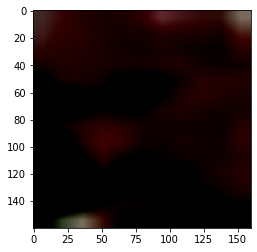

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


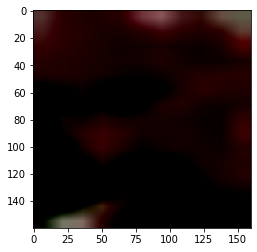

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


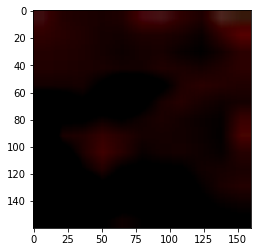

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


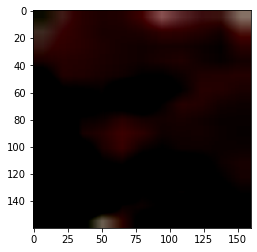

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


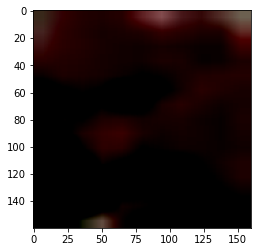

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


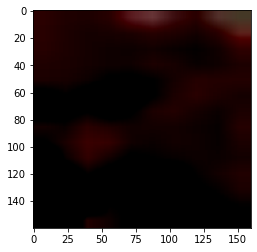

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


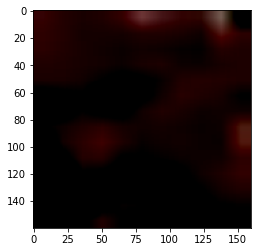

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


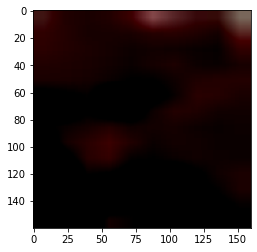

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


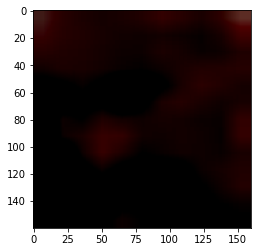

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


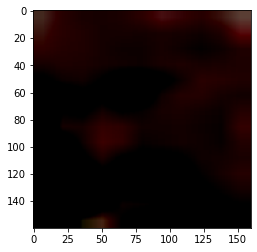

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


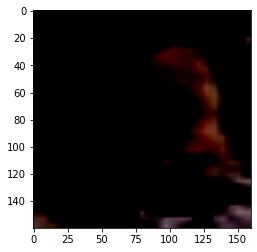

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


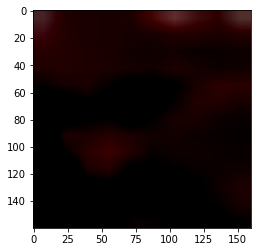

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


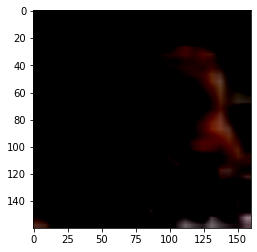

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


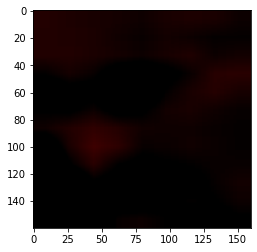

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


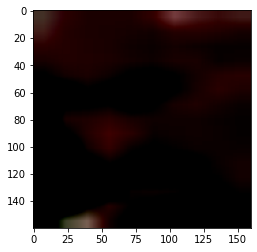

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


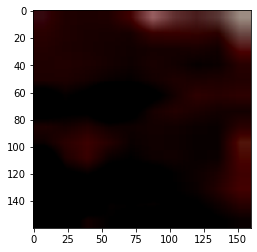

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


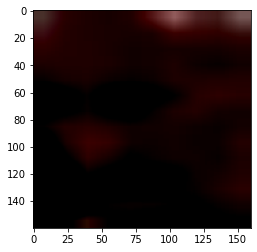

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


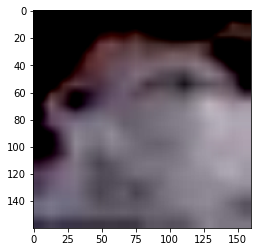

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


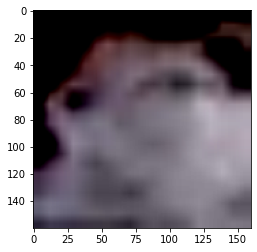

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


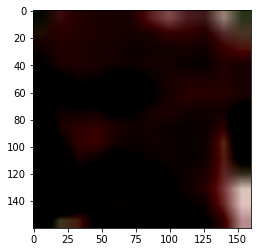

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


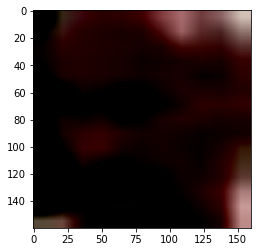

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


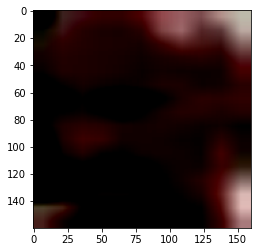

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


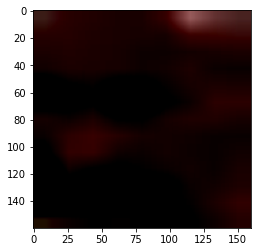

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


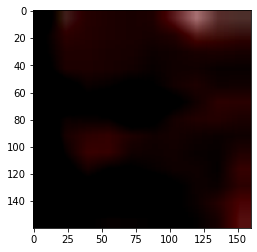

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


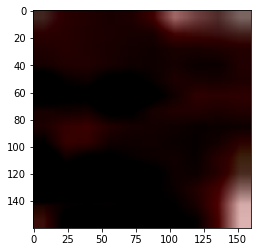

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


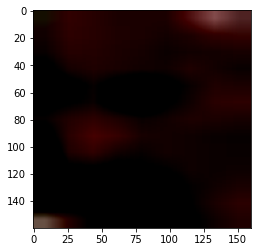

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


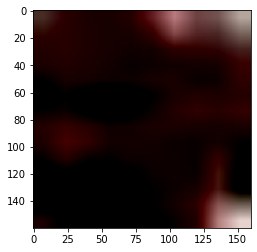

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


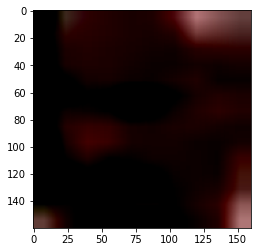

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


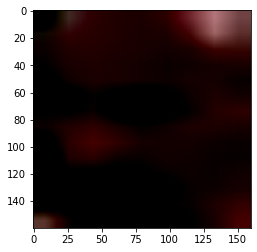

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


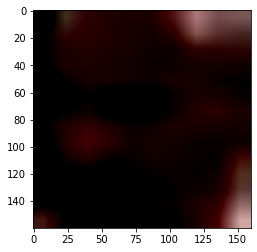

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


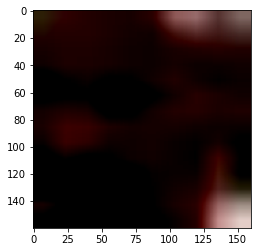

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


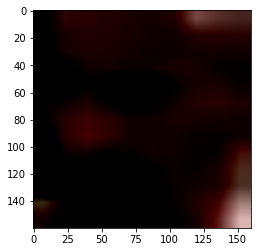

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


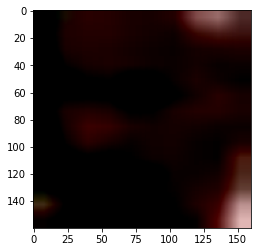

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


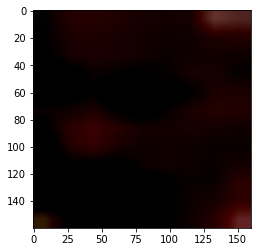

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


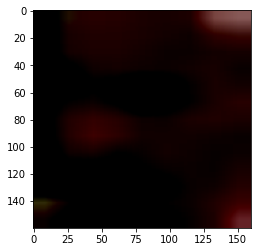

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


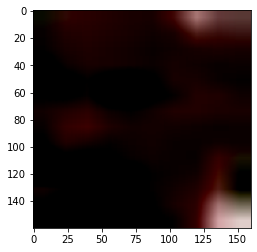

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


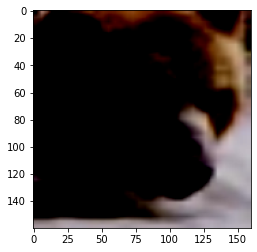

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


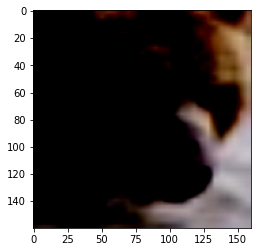

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


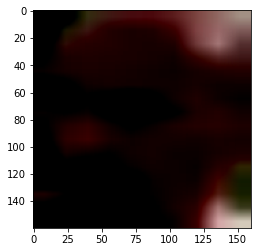

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


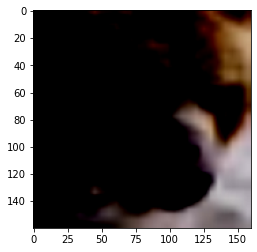

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


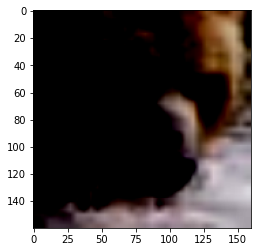

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


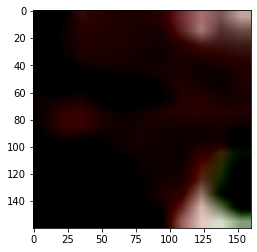

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


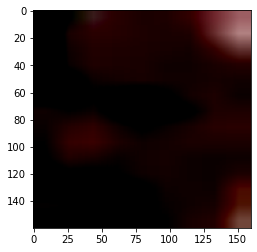

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


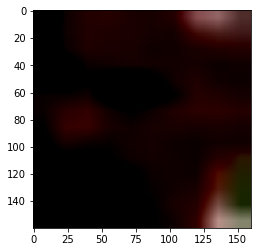

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


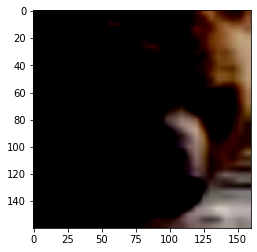

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


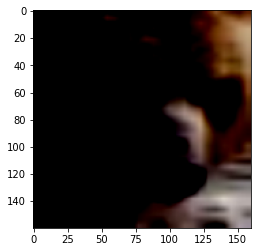

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


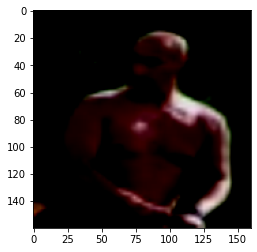

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


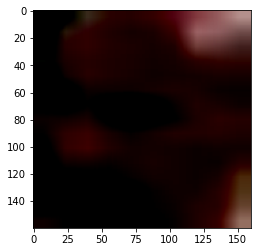

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


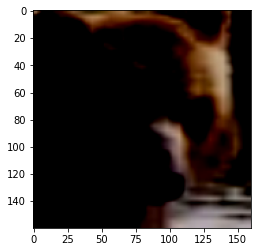

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


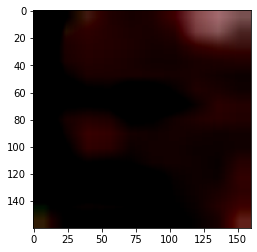

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


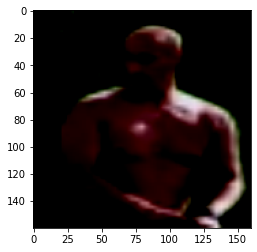

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


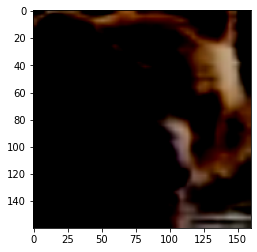

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


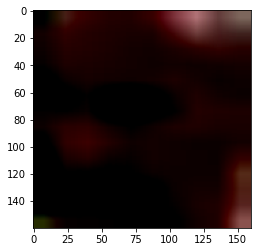

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


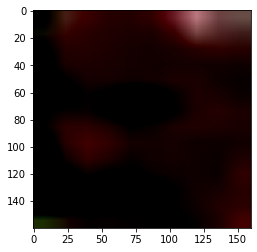

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


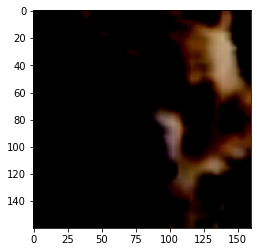

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


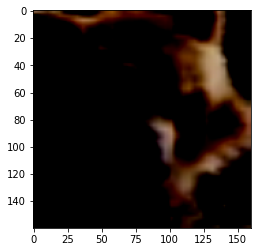

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


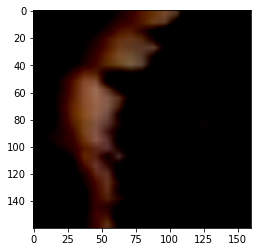

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


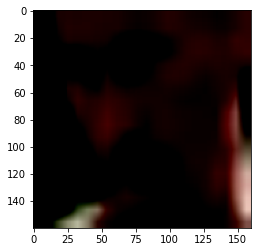

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


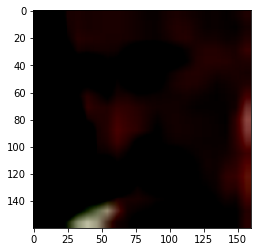

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


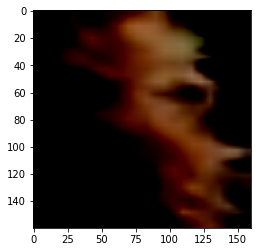

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


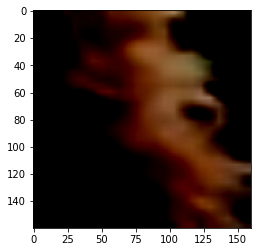

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


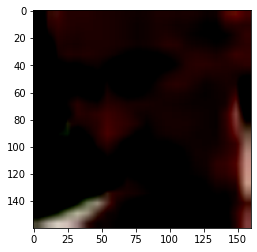

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


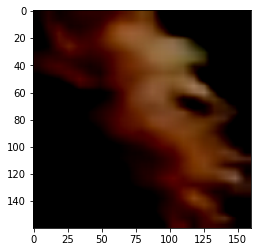

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


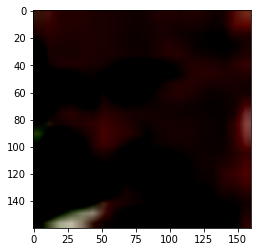

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


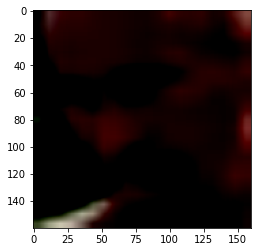

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


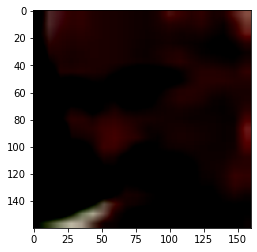

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


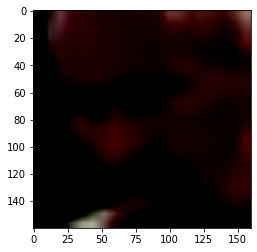

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


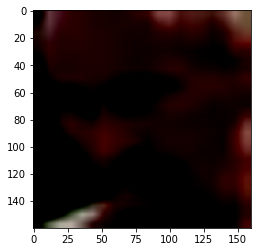

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


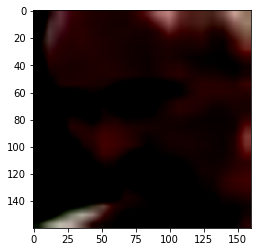

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


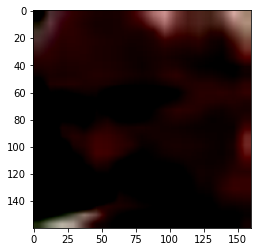

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


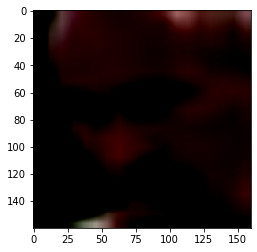

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


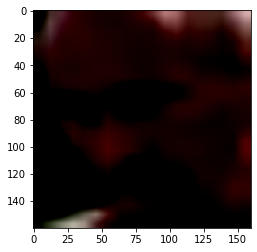

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


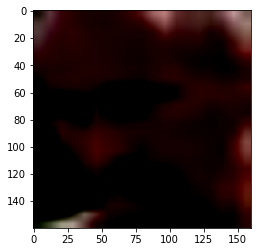

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


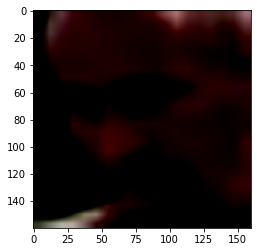

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


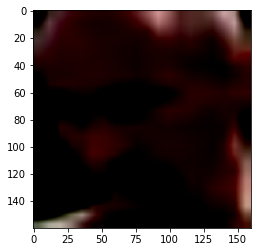

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


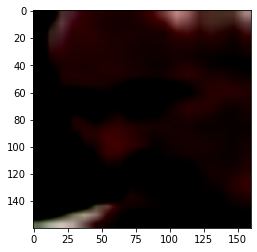

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


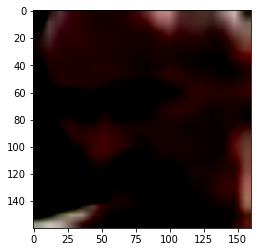

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


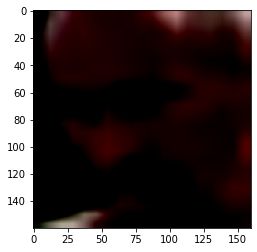

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


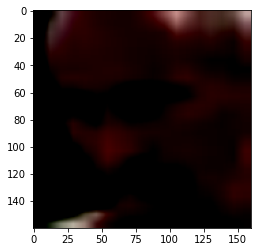

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


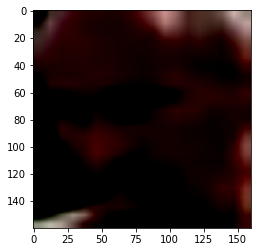

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


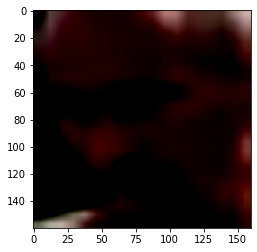

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


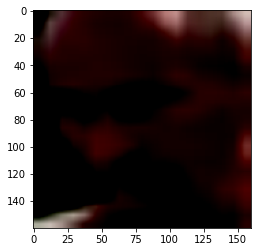

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


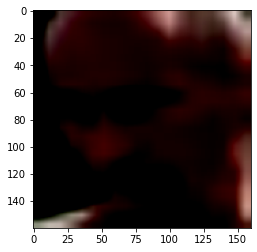

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


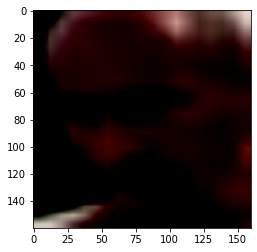

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


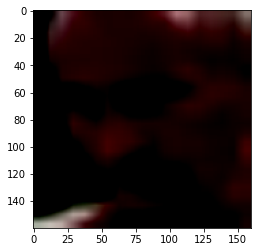

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


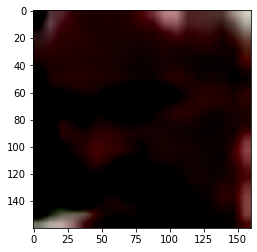

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


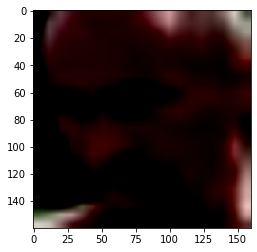

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


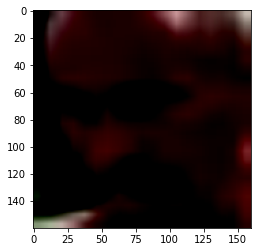

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


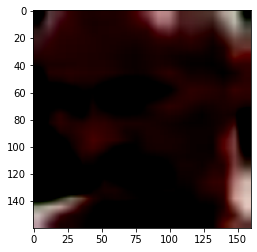

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


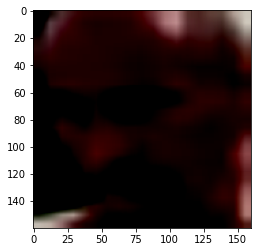

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


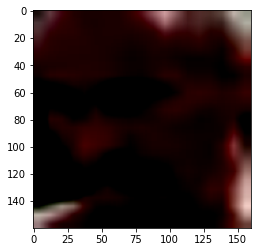

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


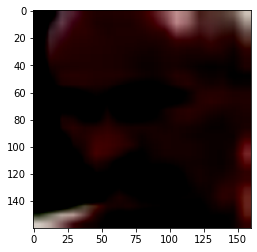

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


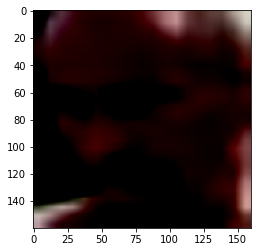

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


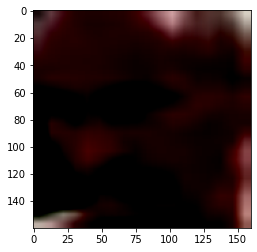

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


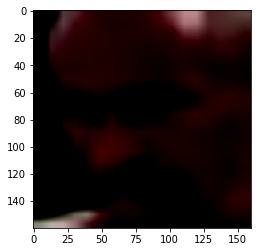

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


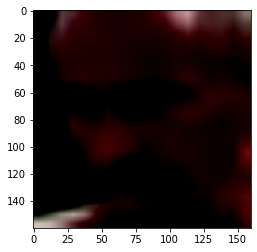

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


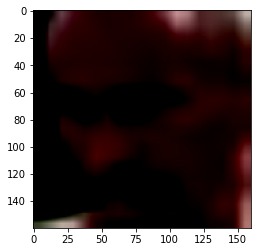

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


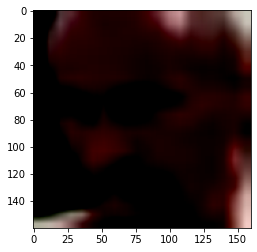

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


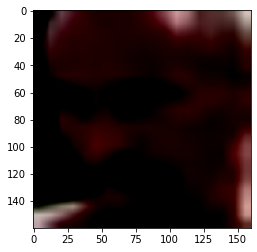

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


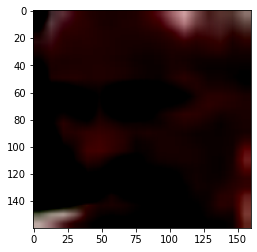

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


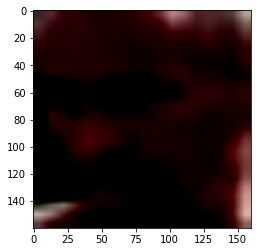

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


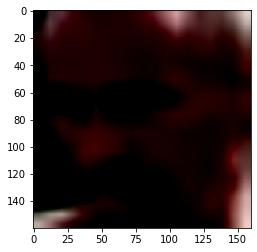

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


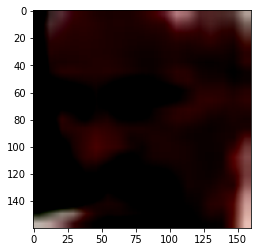

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


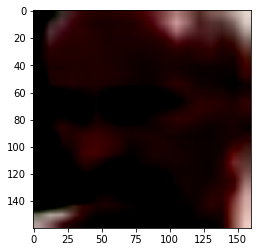

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


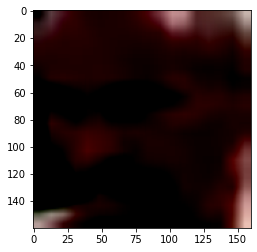

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


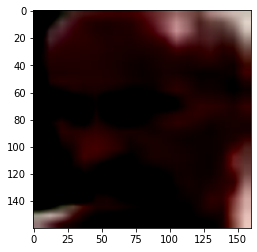

Frames per second (load+detect+embed):   8.73


In [ ]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames = ['https://www.youtube.com/watch?v=-TXBxxPAtb0']

X = []
faces = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

In [ ]:
for i in range(len(faces)):
  if faces[i] is not None:
    faces[i] = faces[i].cpu().numpy()

print(X)
X = X[0].cpu().numpy()

[tensor([[ 0.0127, -0.0013,  0.0082,  ...,  0.0301, -0.0054,  0.0176],
        [ 0.0131,  0.0288,  0.0273,  ...,  0.0129,  0.0156,  0.0120],
        [-0.0579, -0.0196,  0.0108,  ...,  0.0318, -0.0313,  0.0427],
        ...,
        [ 0.0389, -0.0010, -0.0120,  ...,  0.0261, -0.0700,  0.0296],
        [ 0.0477,  0.0012, -0.0327,  ...,  0.0372, -0.0615, -0.0034],
        [ 0.0350, -0.0057, -0.0171,  ...,  0.0376, -0.0779,  0.0404]],
       device='cuda:0')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[[ 0.23046875  0.23046875  0.23046875 ...  0.28515625  0.28515625
     0.28515625]
   [ 0.23046875  0.23046875  0.23046875 ...  0.28515625  0.28515625
     0.28515625]
   [ 0.23046875  0.23046875  0.23046875 ...  0.28515625  0.28515625
     0.28515625]
   ...
   [ 0.12109375  0.12109375  0.12109375 ...  0.13671875  0.13671875
     0.13671875]
   [ 0.12109375  0.12109375  0.12109375 ...  0.13671875  0.13671875
     0.13671875]
   [ 0.12109375  0.12109375  0.12109375 ...  0.13671875  0.13671875
     0.13671875]]

  [[ 0.11328125  0.11328125  0.11328125 ...  0.13671875  0.13671875
     0.13671875]
   [ 0.11328125  0.11328125  0.11328125 ...  0.13671875  0.13671875
     0.13671875]
   [ 0.11328125  0.11328125  0.11328125 ...  0.13671875  0.13671875
     0.13671875]
   ...
   [ 0.05859375  0.05859375  0.05859375 ... -0.16796875 -0.16796875
    -0.16796875]
   [ 0.05859375  0.05859375  0.05859375 ... -0.16796875 -0.16796875
    -0.16796875]
   [ 0.05859375  0.05859375  0.05859375 ... -0.16

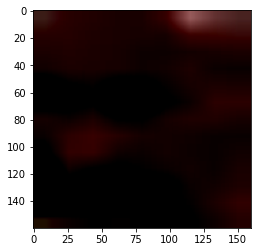

In [ ]:
faces=np.array(faces)
print(faces[156])
X = np.array(X)
print(X.shape)
plt.imshow(faces[156][0].transpose(1,2,0))

#Rodando modelo para pegar features de imagem única(teste)(MTCNN retorna crop avermelhado???)


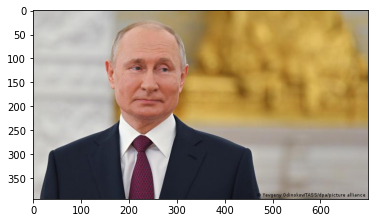

In [ ]:
import imageio as io
img = io.imread("https://static.dw.com/image/57871850_303.jpg")
plt.imshow(img)

In [ ]:
print(img.shape)
img = Image.fromarray(img)
# Resize img to desired size
img = img.resize([int(d * 0.25) for d in img.size])

(394, 700, 3)


In [ ]:
face = []
face.append(mtcnn(img))
print(face[0].shape)

torch.Size([1, 3, 160, 160])


In [ ]:
face = torch.cat(face).to(device)

# Generate facial feature vectors using a pretrained model
feature = resnet(face)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(160, 160, 3)
(1, 512)


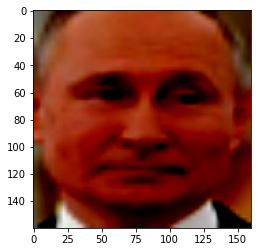

In [ ]:
print(face[0].cpu().numpy().transpose(1,2,0).shape)
plt.imshow(face[0].cpu().numpy().transpose(1,2,0))
print(feature.detach().cpu().numpy().shape)

In [ ]:
query_features = feature.detach().cpu().numpy()
database_features = X

In [ ]:
# this is just to store the number of faces detected in the query image
num_features_query = query_features.shape[0]

# concatenate the features
features = np.vstack((query_features, database_features))
# calculate the mean
mu = np.mean(features, 0)
mu = np.expand_dims(mu, 0)
# extract mean from features and add a bias
features = features - mu + 1e-18
# divide by the standard deviation
features = features / np.expand_dims(np.sqrt(np.sum(np.power(features, 2), 1)), 1)
query_features = features[0:num_features_query]
database_features = features[num_features_query:]

persons_scores = []
all_scores = []
for i, q in enumerate(query_features):
    # calculate cosine distance
    scores_q = q @ np.transpose(database_features)

    # associate confidence score with the label of the dataset and sort based on the confidence
    scores_q = list(zip(scores_q))
    scores_q = sorted(scores_q, key=lambda x: x[0], reverse=True)

    #persons_scores.append((query_bbs[i], generate_rank(scores_q, 10)))
    all_scores.append(scores_q)
all_scores

[[(0.4941029,),
  (0.46643907,),
  (0.465492,),
  (0.44664344,),
  (0.41890767,),
  (0.4161684,),
  (0.41468316,),
  (0.4028167,),
  (0.40127435,),
  (0.3927632,),
  (0.38802916,),
  (0.38798165,),
  (0.37041557,),
  (0.36979738,),
  (0.36875212,),
  (0.3600533,),
  (0.35954535,),
  (0.35063046,),
  (0.34008962,),
  (0.33863005,),
  (0.33455706,),
  (0.3333035,),
  (0.3318314,),
  (0.33017433,),
  (0.32842642,),
  (0.32702935,),
  (0.32568908,),
  (0.31789434,),
  (0.3139091,),
  (0.31008682,),
  (0.30767027,),
  (0.30460605,),
  (0.30356923,),
  (0.2977888,),
  (0.2937074,),
  (0.29136533,),
  (0.28814077,),
  (0.28468993,),
  (0.2762419,),
  (0.27559745,),
  (0.27505055,),
  (0.27025363,),
  (0.26695734,),
  (0.26326856,),
  (0.26224494,),
  (0.2573667,),
  (0.255597,),
  (0.25546932,),
  (0.25098002,),
  (0.24248853,),
  (0.23515195,),
  (0.22209436,),
  (0.19761749,),
  (0.19477262,),
  (0.19411203,),
  (0.18753174,),
  (0.1769976,),
  (0.17318827,),
  (0.16397592,),
  (0.14469427,